In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
from sklearn.cluster import KMeans
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-05-13 10:15:37.403307: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 10:15:37.414416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747152937.424475   64603 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747152937.427125   64603 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 10:15:37.439705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [97]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get observations
obs_biome = xr.open_dataset('calibration_obsStatistics_sudokuBiomes.nc')
obs_biome['TVC_stdev'].loc[{'biome': 12}] = 100

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

### Load Parameter sets

In [29]:
with open("./checkpoints_PhilosophyA/checkpoint_step_990.pkl", "rb") as f:
    def_990 = pickle.load(f)

In [68]:
with open("./checkpoints_PhilosophyB/checkpoint_step_990.pkl", "rb") as f:
    rand_990 = pickle.load(f)

In [30]:
params = def_990['params'].numpy()
universal_params = np.tile(default_params[u_params].iloc[[0]].to_numpy(),(len(params),1))
master_params = np.concatenate([universal_params,params],axis=1)
cal_params = pd.DataFrame(master_params, columns = default_params.columns)

In [98]:
cal_params = pd.read_csv('./checkpoints_close2default/calibrated_sets_defaultPrior_lambda14_051225.csv')

### select only sets with all biomes and variables within 1 stdev of observational target

In [99]:
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai_compiled/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp_compiled/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass_compiled/'
}

biomes = [1,2,3,5,6,7,8,9,10,11,12,13]
param_indices = []
targets = []
stdevs = []
emulators = []  

for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b,u_params,pft_params)
    param_ix = [default_params.columns.get_loc(p)for p in param_names]
    
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    
    targets.extend([
        obs_biome.LAI_mean.isel(biome=b).values,
        obs_biome.GPP_mean.isel(biome=b).values,
        obs_biome.TVC_mean.isel(biome=b).values
    ])
    stdevs.extend([
        obs_biome.LAI_stdev.isel(biome=b).values,
        obs_biome.GPP_stdev.isel(biome=b).values,
        obs_biome.TVC_stdev.isel(biome=b).values
    ])

    emulators.extend([
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ])
    
targets = tf.stack(targets, axis=0)  
stdevs = tf.stack(stdevs, axis=0)   


In [100]:
# ——— for fast graph execution ———
lengths = [len(arr) for arr in param_indices]     # list of Python ints

emulator_array = []
for m,input_dim in zip(emulators, lengths):
    sig = tf.TensorSpec([None, input_dim], tf.float64)
    f = tf.function(lambda X, _m=m: _m.compiled_predict_f(X)[0], input_signature=[sig])
    emulator_array.append(f)

In [101]:
nBatch = np.shape(cal_params)[0]

z_per_metric = []

# loop over metrics and biomes in stacked 1D arrays. 
for i in range(len(emulator_array)):
    model   = emulator_array[i]

    target_tiled = np.tile(targets[i],(nBatch,1))
    stdev_tiled = np.tile(stdevs[i],(nBatch,1))

    ix  = param_indices[i]          
    x_biome = cal_params.values[:,ix]
    y_pred = model(x_biome)
    z = np.abs((y_pred - target_tiled)/stdev_tiled)
    
    z_per_metric.append(z)
    
loss_per_sample = np.max(z_per_metric,axis=0)

In [ ]:
# hard to get within 1stdev
#1,2,4,6,7,9,12,13,16,22,24,25,27,29,35
#1gpp,1tvc,2gpp,3lai,3gpp,5lai,6lai,6gpp,7gpp,9gpp,10lai,10gpp,11lai,11tvc,13tvc

In [102]:
maxZ = 1
ix = np.where(loss_per_sample<maxZ)[0]
paramsets = cal_params.iloc[ix]

In [103]:
np.shape(paramsets)

(327, 236)

In [104]:
loss_per_sample = np.sum(z_per_metric,axis=0)

In [105]:
ix = np.argmin(loss_per_sample)
best_set = cal_params.iloc[[ix]]

### Plot posteriors

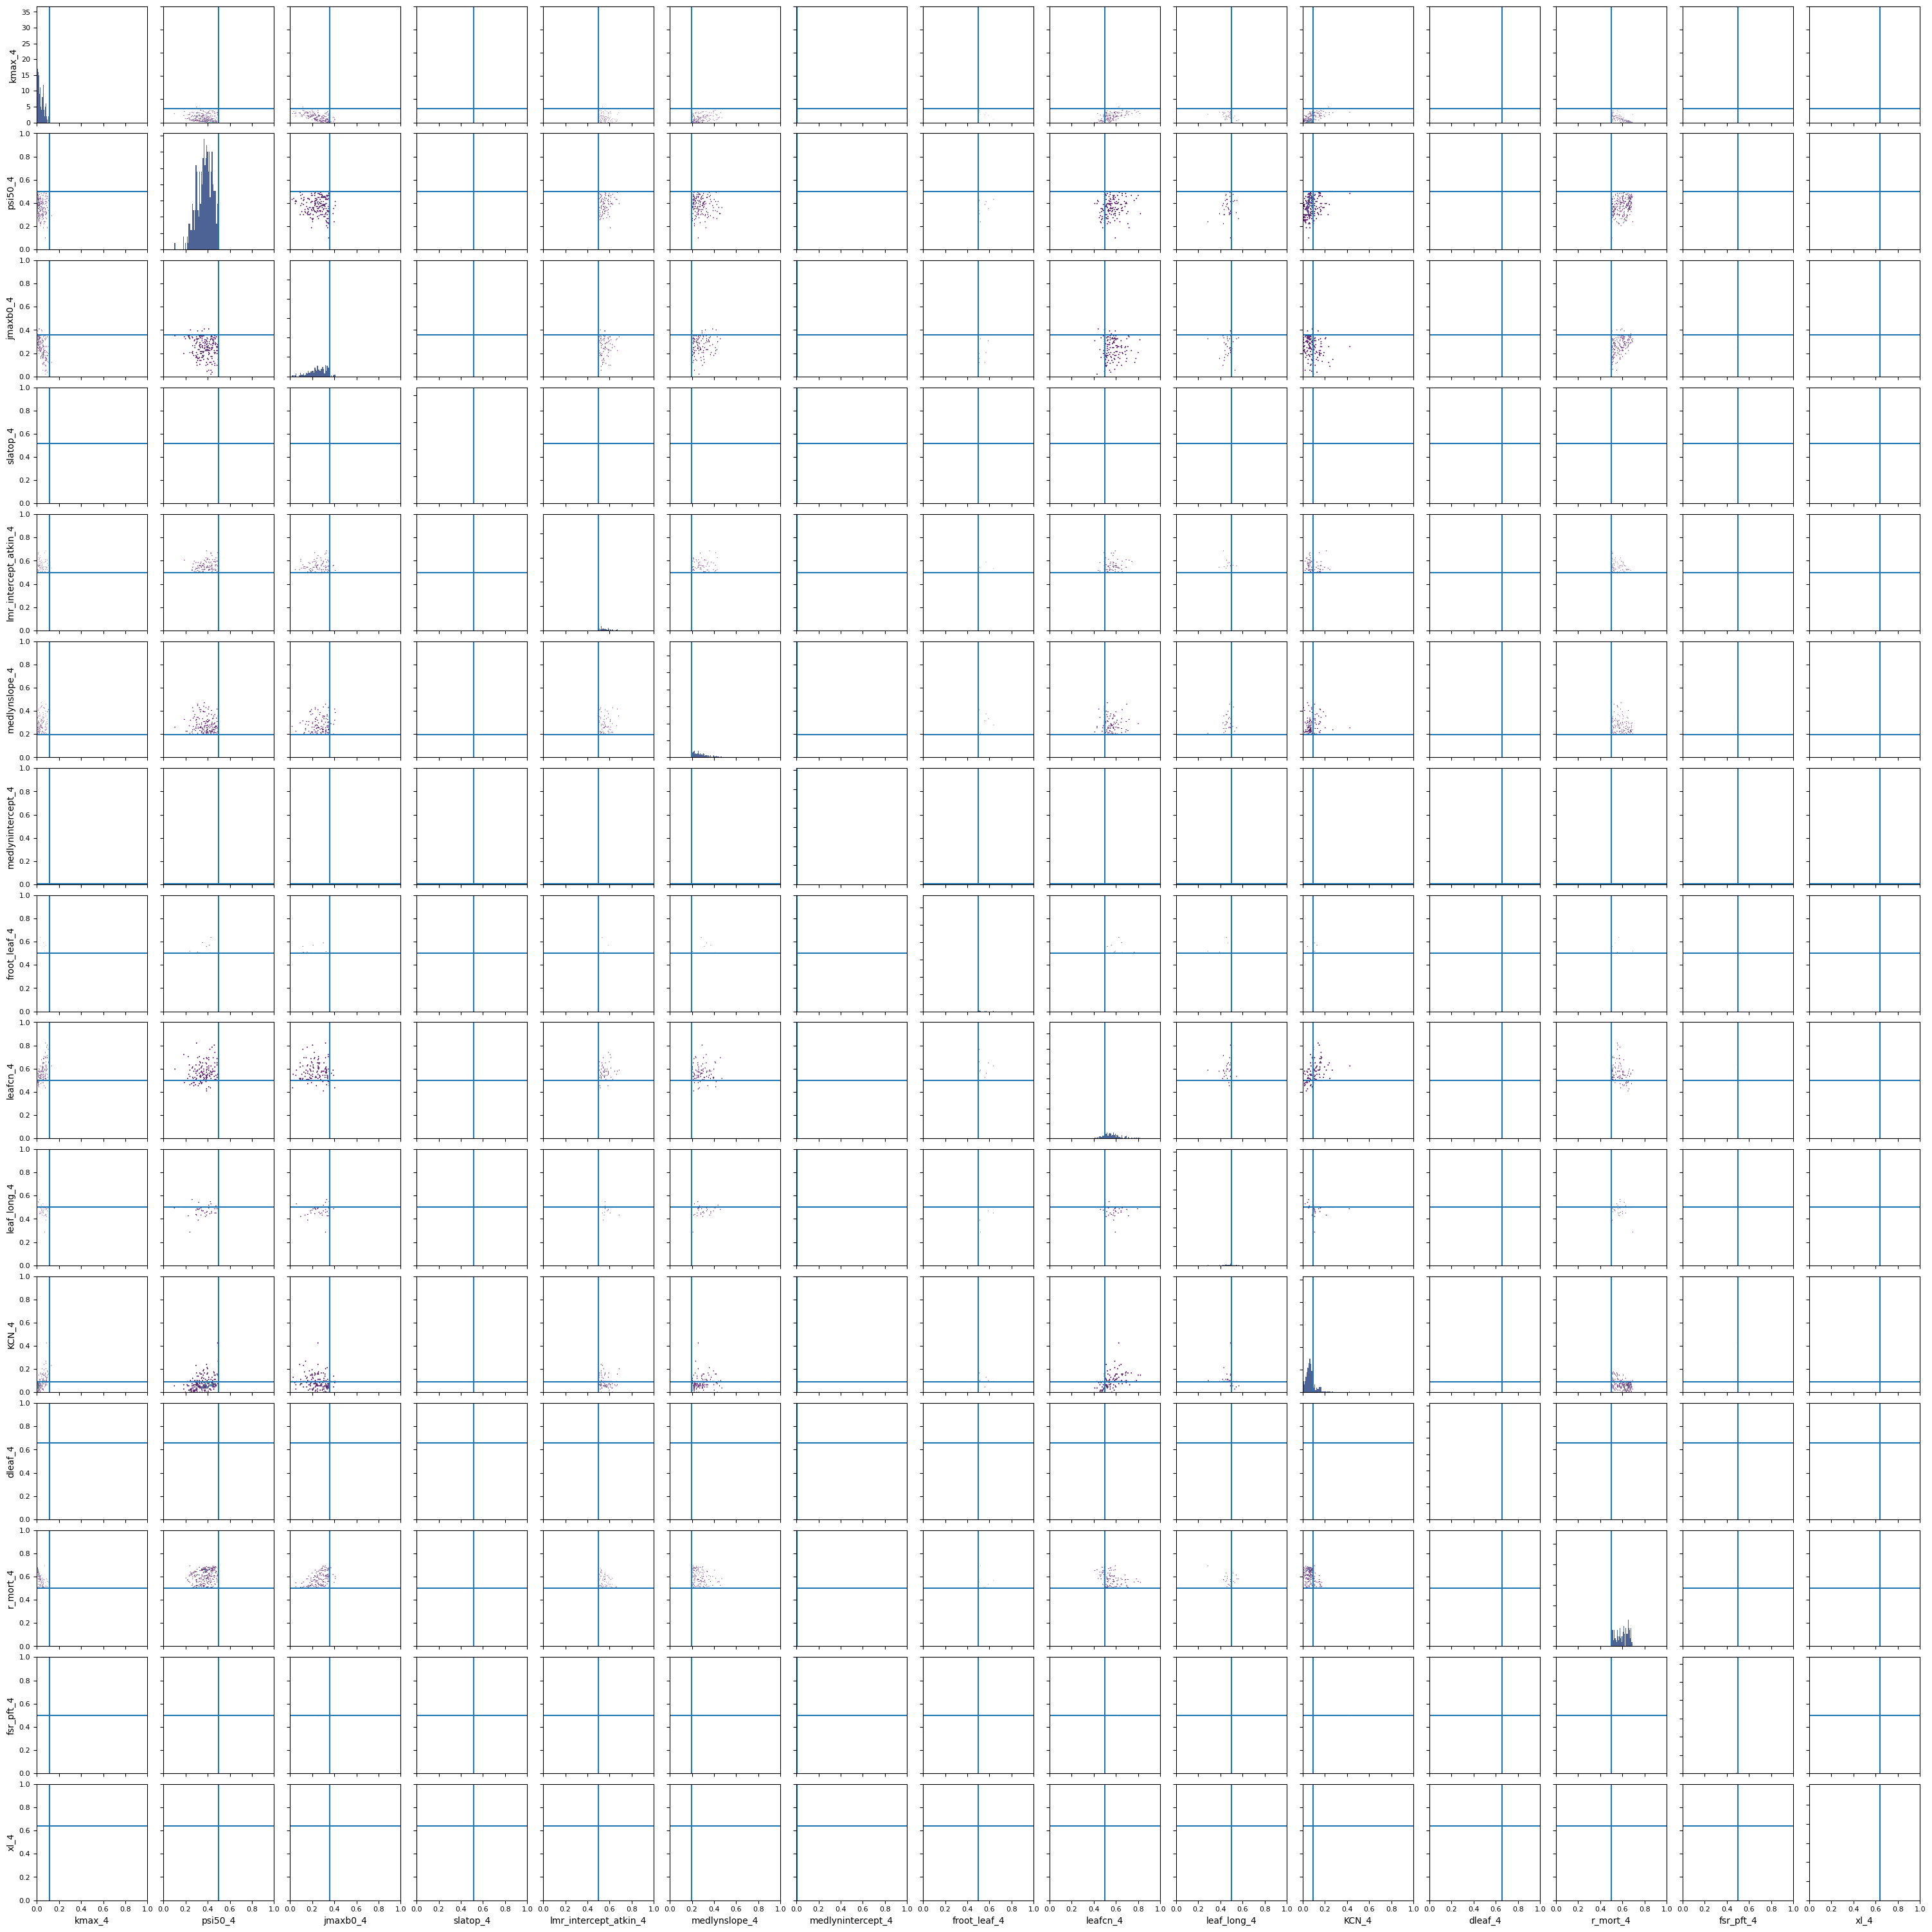

In [38]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
#data = cal_params[pft_param_names]
data = paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.set_xlim([0,1])
            ax.axvline(default_params[pft_param_names[j]].values)
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=40,
                cmap='viridis',       
                mincnt=1,           # Only show bins with data
                linewidths=0
            )

            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            
        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'philB_step1000.png', dpi = 300)

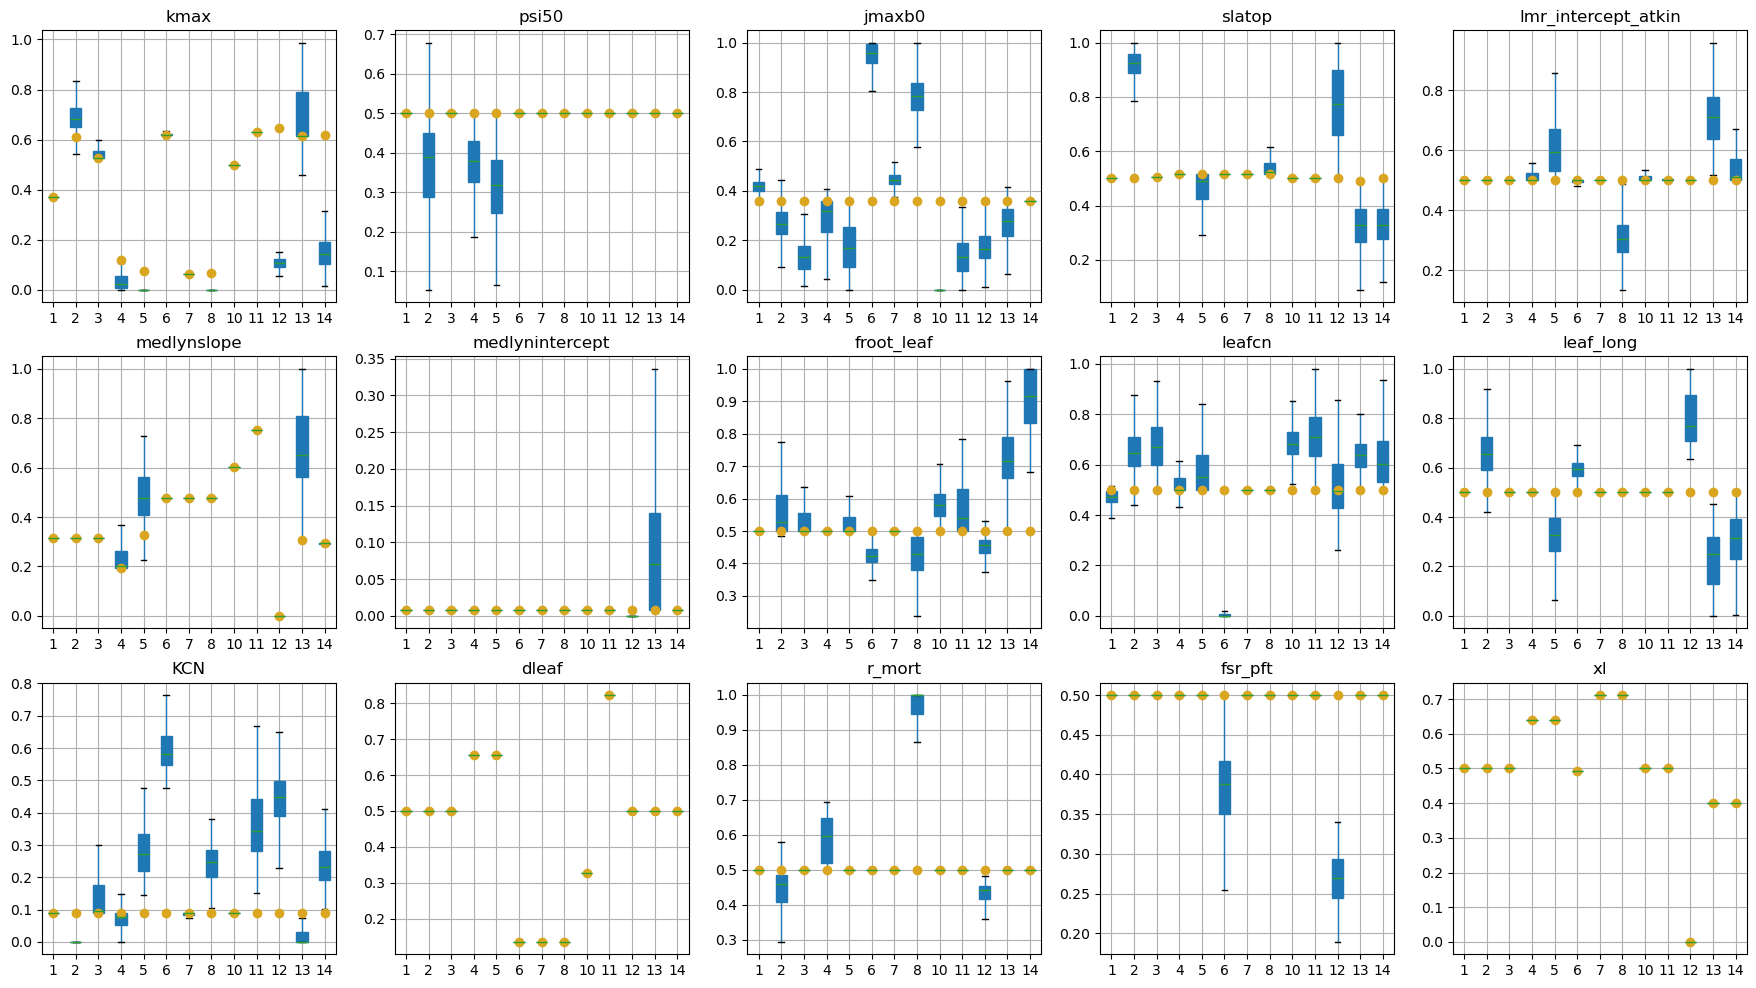

In [36]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, param in enumerate(pft_params):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for pft in pft_ids]
    data = paramsets[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based

    plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_ids, rotation=0)
    plt.title(param)
plt.savefig('./figs/posteriors_close2def_subset<1stdev.png', dpi=300)

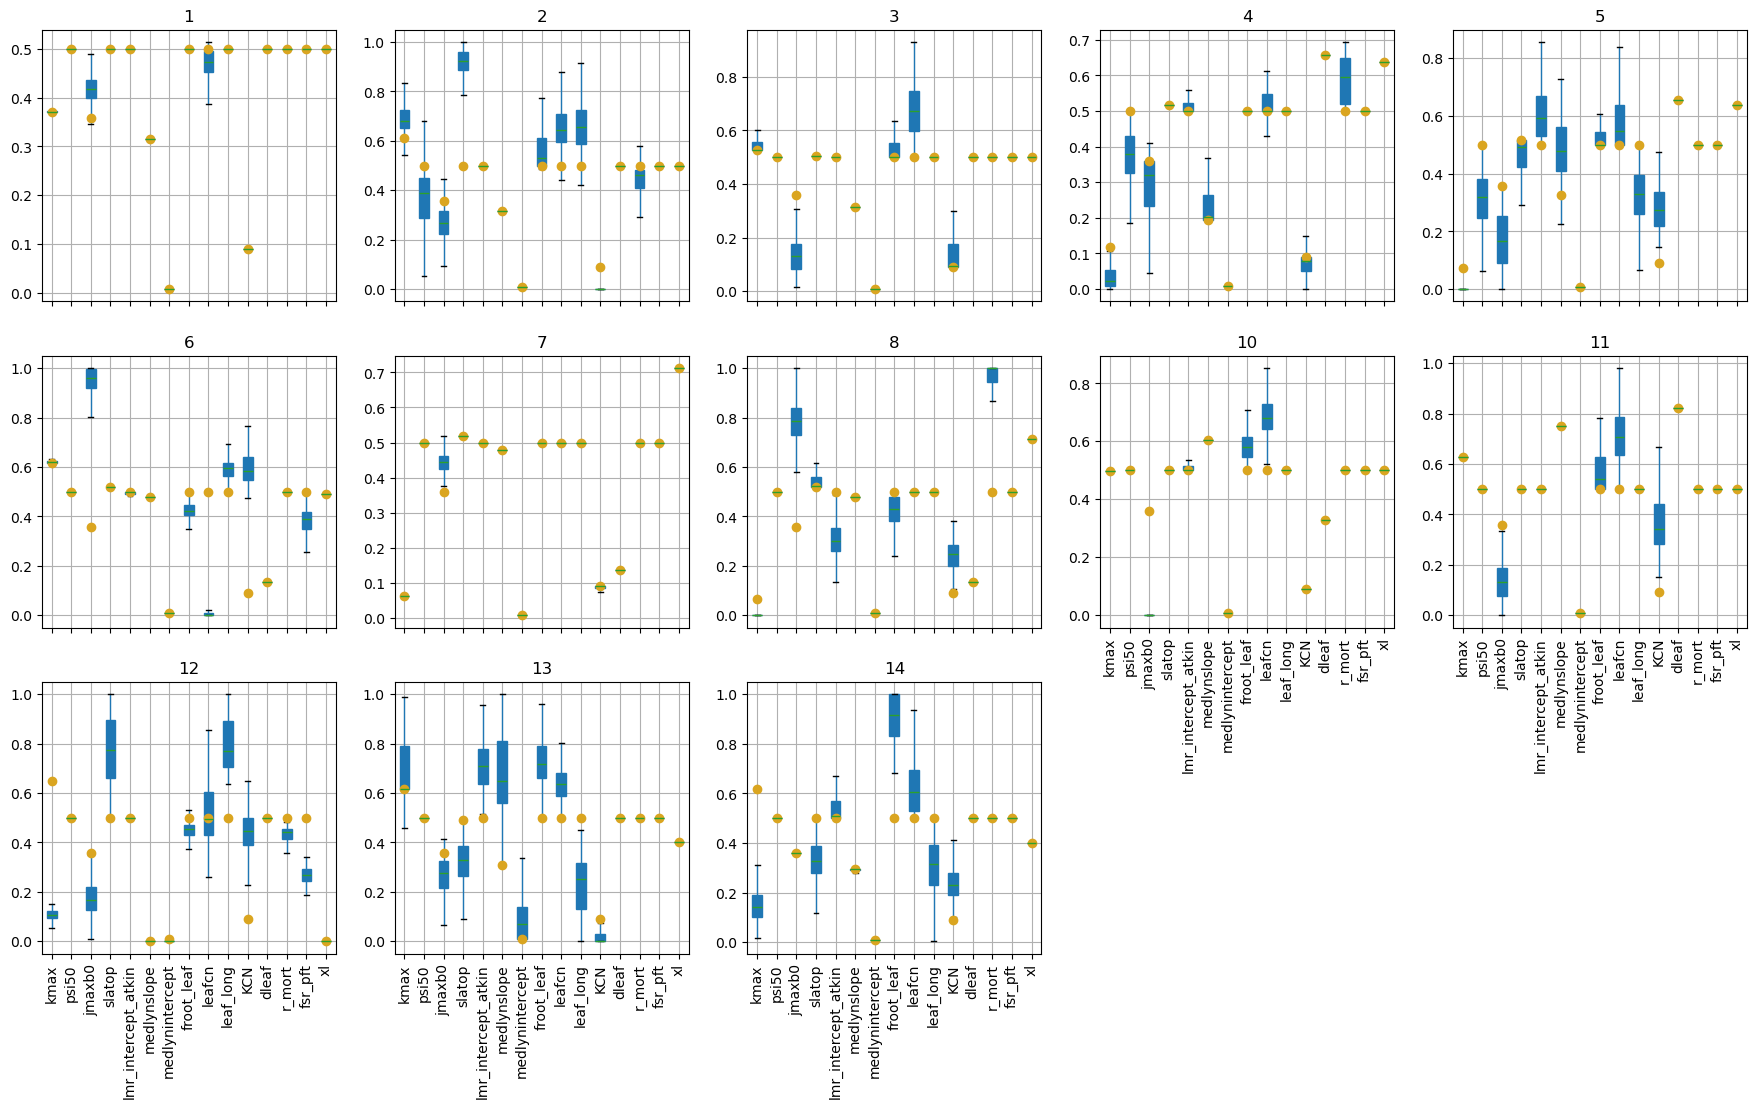

In [37]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, pft in enumerate(pft_ids):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    data = paramsets[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based

    if pft>8:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_params, rotation=90)
    else:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1),labels=[])
    plt.title(pft)
plt.savefig('./figs/posteriors_close2def_subset<1stdev_byPFT.png', dpi=300)

## Biome evaluation

### Emulate the other metrics

In [54]:
paths = {
    'vcmx25z': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biome_vcmx25z/',
    'cue': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biome_cue/',
    'alloc': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biome_alloc/',
    'wstress': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biome_wstress/',
}

vars = ['vcmx25z','cue','alloc','wstress']
out_data = {var: [] for var in vars}
biome_names = [biome['name'] for biome in biome_configs[1:]] 
n_biomes = len(biome_names)

for b,biome in enumerate(biome_configs[1:],start=1):
    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = paramsets[cols]

    for var in vars:
        emulator = tf.saved_model.load(f"{paths[var]}{biome['name']}")
        y_pred, _ = emulator.predict(samp)
        out_data[var].append(y_pred.numpy().squeeze())


In [55]:
# Now convert to Dataset
n_samp = out_data[vars[0]][0].shape[0]
biomes = biome_names
samples = np.arange(n_samp)

ds_vars = {}
for var in vars:
    data_array = np.stack(out_data[var], axis=1)  # shape: (nsamp, nbiomes)
    ds_vars[var] = (['sample', 'biome'], data_array)

ds = xr.Dataset(ds_vars, coords={'sample': samples, 'biome': biomes})


### Cluster in parameter space

In [56]:
nClusters = 3

# Select biome
biome = biome_configs[1]  # e.g., biome index 2
pfts = biome['pfts']
cols = u_params
for p in pfts:
    param_names = [f"{param}_{p}" for param in pft_params]
    cols = np.concatenate([cols, param_names])

# Extract the relevant subset of parameter vectors
X_param = paramsets[cols].values  # shape (n_samples, n_params)

# Cluster in parameter space
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X_param)
param_cluster_labels = kmeans.labels_  # shape (n_samples,)


/glade/derecho/scratch/linnia/tmp/ipykernel_8172/3123904110.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x0,y0,s=6,cmap='tab10')
/glade/derecho/scratch/linnia/tmp/ipykernel_8172/3123904110.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x0,y0,s=6,cmap='tab10')
/glade/derecho/scratch/linnia/tmp/ipykernel_8172/3123904110.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x0,y0,s=6,cmap='tab10')
/glade/derecho/scratch/linnia/tmp/ipykernel_8172/3123904110.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x0,y0,s=6,cmap='tab10')
/glade/derecho/scratch/linnia/tmp/ipykernel_8172/3123904110.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x0,y0,s=6,cmap='tab10')
/glade/derecho/scratch/li

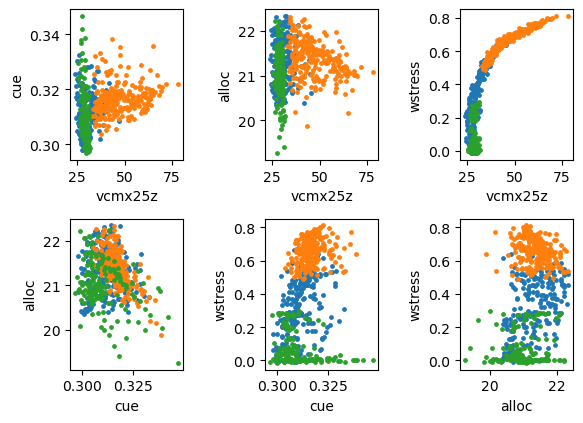

In [57]:
# visualize clusters in metric space
vars = ['vcmx25z','cue','alloc','wstress']

plt.figure(figsize=(6,6))
plt.subplot(3,3,1)
var1 = vars[0]
var2 = vars[1]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.subplot(3,3,2)
var1 = vars[0]
var2 = vars[2]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.subplot(3,3,3)
var1 = vars[0]
var2 = vars[3]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.subplot(3,3,4)
var1 = vars[1]
var2 = vars[2]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.subplot(3,3,5)
var1 = vars[1]
var2 = vars[3]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.subplot(3,3,6)
var1 = vars[2]
var2 = vars[3]
for cluster in range(nClusters):
    ix = np.where(param_cluster_labels==cluster)[0]
    x0 = ds[var1].sel(biome=biome['name'],sample=ix)
    y0 = ds[var2].sel(biome=biome['name'],sample=ix)
    plt.scatter(x0,y0,s=6,cmap='tab10')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.tight_layout()

### Cluster in metric space

In [115]:
from sklearn.cluster import KMeans

In [58]:
# Select biome name or index
biome_name = 'Tropical rainforest'  

# Extract feature matrix: shape (n_samples, n_vars)
X = np.stack([
    ds['vcmx25z'].sel(biome=biome_name).values,
    ds['cue'].sel(biome=biome_name).values,
    ds['alloc'].sel(biome=biome_name).values,
    ds['wstress'].sel(biome=biome_name).values
], axis=1)

# Cluster the samples
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X)
labels = kmeans.labels_  # shape: (n_samples,)

# add to dataset
ds['cluster'] = (('sample', 'biome'), np.full((len(ds.sample), len(ds.biome)), np.nan))
ds['cluster'].loc[dict(biome=biome_name)] = labels


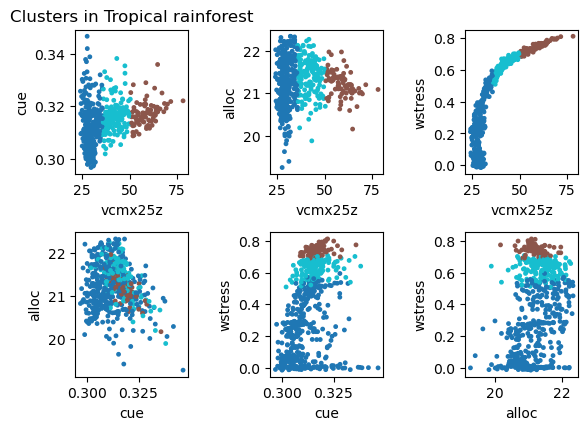

In [59]:
plt.figure(figsize=(6,6))

plt.subplot(3,3,1)
plt.scatter(X[:, 0], X[:, 1], s=6, c=labels, cmap='tab10')
plt.xlabel(vars[0])
plt.ylabel(vars[1])
plt.title(f'Clusters in {biome_name}')

plt.subplot(3,3,2)
plt.scatter(X[:, 0], X[:, 2], s=6, c=labels, cmap='tab10')
plt.xlabel(vars[0])
plt.ylabel(vars[2])

plt.subplot(3,3,3)
plt.scatter(X[:, 0], X[:, 3], s=6,  c=labels, cmap='tab10')
plt.xlabel(vars[0])
plt.ylabel(vars[3])

plt.subplot(3,3,4)
plt.scatter(X[:, 1], X[:, 2], s=6, c=labels, cmap='tab10')
plt.xlabel(vars[1])
plt.ylabel(vars[2])

plt.subplot(3,3,5)
plt.scatter(X[:, 1], X[:, 3], s=6,  c=labels, cmap='tab10')
plt.xlabel(vars[1])
plt.ylabel(vars[3])

plt.subplot(3,3,6)
plt.scatter(X[:, 2], X[:, 3], s=6, c=labels, cmap='tab10')
plt.xlabel(vars[2])
plt.ylabel(vars[3])

plt.tight_layout()

## Global

In [108]:
paths = {
    'vcmx25z': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/vcmx25z',
    'cue': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/cue/',
    'ncost': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/ncost/',
    'alloc': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/alloc/',
    'wstress': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/wstress/',
}

vars = ['vcmx25z','cue','ncost','alloc','wstress']
out_data = {var: [] for var in vars}

cols = default_params.columns
samp = paramsets[cols]

for var in vars:
    emulator = tf.saved_model.load(f"{paths[var]}")
    y_pred, _ = emulator.predict(samp)
    out_data[var].append(y_pred.numpy().squeeze())


In [109]:
# Now convert to Dataset
n_samp = out_data[vars[0]][0].shape[0]
samples = np.arange(n_samp)

ds_vars = {}
for var in vars:
    data_array = out_data[var][0]
    ds_vars[var] = (['sample'], data_array)

ds = xr.Dataset(ds_vars, coords={'sample': samples})


#### Cluster in parameter space

In [97]:
nClusters = 5

cols = default_params.columns.values
X_param = paramsets[cols].values  

# Cluster in parameter space
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X_param)
param_cluster_labels = kmeans.labels_  # shape (n_samples,)

/glade/derecho/scratch/linnia/tmp/ipykernel_8172/4195843598.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x0, y0, s=6, cmap='tab10')


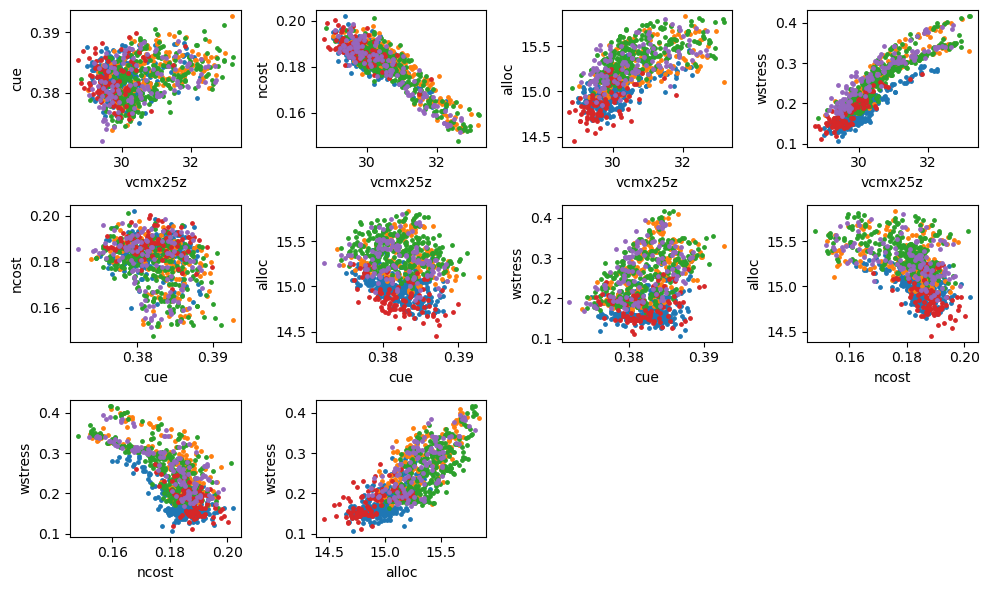

In [98]:
import itertools
# list of variables and all unique pairs
vars = ['vcmx25z', 'cue', 'ncost', 'alloc', 'wstress']
pairs = list(itertools.combinations(vars, 2))

plt.figure(figsize=(10, 6))

# iterate over each pair and subplot index
for idx, (var1, var2) in enumerate(pairs, start=1):
    ax = plt.subplot(3,4, idx)
    # plot each cluster in this var-var space
    for cluster in range(nClusters):
        ix = np.where(param_cluster_labels == cluster)[0]
        x0 = ds[var1].sel(sample=ix)
        y0 = ds[var2].sel(sample=ix)
        ax.scatter(x0, y0, s=6, cmap='tab10')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

plt.tight_layout()


#### Cluster in metric space

In [110]:
import itertools

In [111]:
# Extract feature matrix: shape (n_samples, n_vars)
nClusters=5
X = np.stack([
    ds['vcmx25z'].values,
    ds['cue'].values,
    ds['ncost'].values,
    ds['alloc'].values,
    ds['wstress'].values
], axis=1)

# Cluster the samples
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X)
labels = kmeans.labels_  # shape: (n_samples,)

# add to dataset
ds['cluster'] = ('sample', labels)

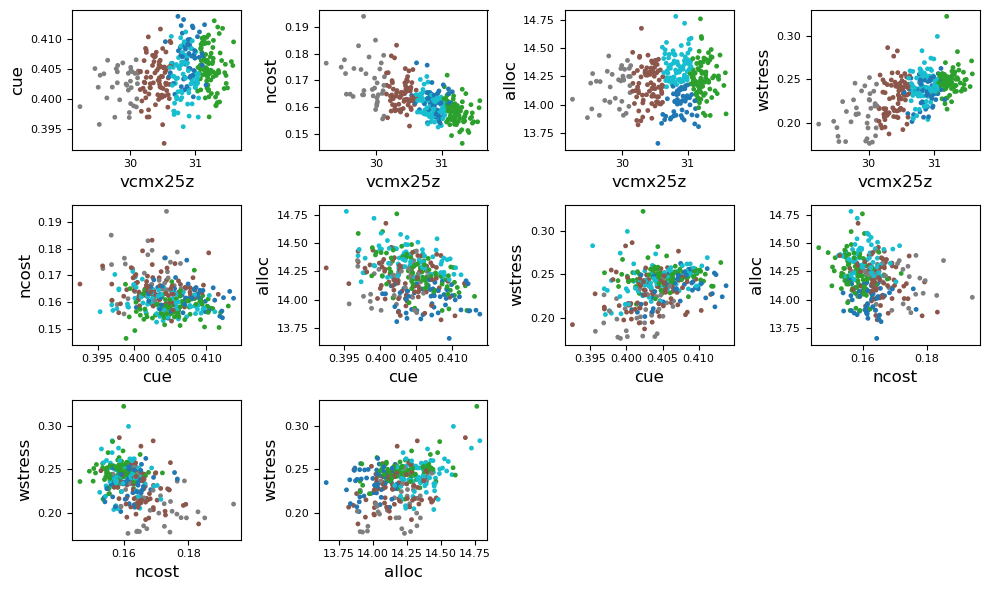

In [112]:
n_vars = X.shape[1]
pairs = list(itertools.combinations(range(n_vars), 2))
n_plots = len(pairs)

fig = plt.figure(figsize=(10, 6))

for idx, (i, j) in enumerate(pairs, start=1):
    ax = fig.add_subplot(3, 4, idx)
    ax.scatter(X[:, i], X[:, j], s=6, c=labels, cmap='tab10')
    ax.set_xlabel(vars[i])
    ax.set_ylabel(vars[j])

plt.tight_layout()
plt.savefig('clusters_metricspace_close2def.png',dpi=300)

### Select paramsets

In [114]:
labels = ds['cluster'].values
clusters = np.unique(labels)

# pick 2 random indices per cluster
selected_idxs = []
rng = np.random.default_rng(seed=0) 
for c in clusters:
    # find all sample-positions belonging to cluster c
    idxs = np.where(labels == c)[0]
    if len(idxs) >= 2:
        chosen = rng.choice(idxs, size=2, replace=False)
    else:
        # if fewer than 2 members, just take them all
        chosen = idxs
    selected_idxs.extend(chosen.tolist())

selected_idxs = np.array(selected_idxs, dtype=int)
print("Selected sample indices:", selected_idxs)


Selected sample indices: [248 215  82  75   1  20 244 225 173 201]


In [115]:
#check
cols = default_params.columns
samp = paramsets[cols].iloc[selected_idxs]

emulator = tf.saved_model.load(f"{paths['wstress']}")
y_pred, _ = emulator.predict(samp)
retest = y_pred.numpy().squeeze()


In [116]:
retest

array([0.26256265, 0.24932211, 0.24679723, 0.23662454, 0.21698536,
       0.23072373, 0.24272095, 0.20797813, 0.24821868, 0.20857356])

In [117]:
ds['wstress'].isel(sample=selected_idxs).values

array([0.26256265, 0.24932211, 0.24679723, 0.23662454, 0.21698536,
       0.23072373, 0.24272095, 0.20797813, 0.24821868, 0.20857356])

In [123]:
selected_sets = pd.concat([samp,best_set])

In [124]:
selected_sets.to_csv('./paramsets/close2def_test11.csv')

## Write paramsets

In [10]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [127]:
csv='~/ctsm6_ppe/gen_ensembles/gen_paramfiles/ctsm6cal_paramranges_05122025.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
params=df_main['param'].values

In [128]:
filename = './paramsets/close2def_test11.csv'
selected_paramsets = pd.read_csv(filename)

In [130]:
# create dictionary of paramsets
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
pset_dict = {}

for param in params:
    if param in pft_params:
        psets = np.ones((len(selected_paramsets),79))*0.5
        cols = [f"{param}_{i}" for i in pft_ids]
        psets[:,pft_ids] = selected_paramsets[cols].values
        pset_dict[param] = psets
    else:
        pset_dict[param] = selected_paramsets[param].values

In [131]:
# fix some individual PFTs/params
extra_pfts = [0,9,16]
for i in range(1):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
# set c3 crops equivalent to c3 grasses
for par in pft_params:
    pset_dict[par][:,15] = pset_dict[par][:,13]

In [132]:
np.save('./paramsets/close2def_test11.npy', pset_dict)